In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import time

2024-08-23 16:55:31.360716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 16:55:31.377973: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 16:55:31.382707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 16:55:31.394147: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 16:55:32.339324: W tensorflow/compiler/tf2

In [2]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is 
data directory is ../human_pose_local/archive/Human Action Recognition


### Load the data

In [3]:
# file_name = 'movenet_thunder_mobilenet_small'
# file_name = 'movenet_lightning_mobilenet_large'
# file_name = 'movenet_thunder_mobilenet_large'
# file_name = 'movenet_lightning_mobilenet_small'

In [4]:
file_name = "movenet_thunder_mobilenet_large"

In [5]:
df = pd.read_pickle(data_directory + '/' + file_name + '.pkl')

In [6]:
# apply the function to the dataframe
df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
df['category'] = df['category'].apply(lambda x: np.array(x))

In [7]:
# shape of the data
print('keypoints shape: ', df['keypoints'].iloc[0].shape)
print('object shape: ', df['object'].iloc[0].shape)
print('obj_vector shape: ', df['obj_vector'].iloc[0].shape)

keypoints shape:  (51,)
object shape:  (5, 1)
obj_vector shape:  (5, 100)


In [8]:
# set to 0 the keypoints with score < 0.3
def filter_keypoints(x):
    x[x[:, 2] < 0.3] = 0
    return x

# df['keypoints'] = df['keypoints'].apply(lambda x: filter_keypoints(x))

# keep only the positions of the keypoints
def get_positions(x):
    return x[:, :2]

# df['keypoints'] = df['keypoints'].apply(lambda x: get_positions(x))

# set to 0 the object with score < 0.1
def filter_object(x):
    x[x[:, 0] < 0.1] = 0
    return x

# df['object'] = df['object'].apply(lambda x: filter_object(x))

In [9]:
# number of object to consider
n_objects = 5

In [10]:
df['obj_input'] = df.apply(lambda x: np.sum(x['object'][-n_objects:]
                                            *x['obj_vector'][-n_objects:], axis=0), axis=1)
df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())

In [11]:
df

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words,obj_input
0,Image_1.jpg,sitting,11,"[0.0882076621055603, 0.6247615814208984, 0.756...","[[0.60480165], [0.04718776], [0.032203343], [0...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo...","[-0.20592125285495, 0.3260203410991888, -0.008..."
1,Image_2.jpg,using_laptop,14,"[0.30178800225257874, 0.9912914037704468, 0.80...","[[0.7418762], [0.040941585], [0.012892539], [0...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ...","[0.2683790374652541, -0.6670002713657828, 0.87..."
2,Image_3.jpg,hugging,7,"[0.20708897709846497, 0.6019015908241272, 0.42...","[[0.1416007], [0.13604547], [0.05453948], [0.0...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape...","[-0.02030288063444885, 0.23200371996866265, 0...."
3,Image_4.jpg,sleeping,12,"[0.37268558144569397, 0.1374012678861618, 0.20...","[[0.6505104], [0.06191667], [0.027490702], [0....","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia...","[-0.8215984234954313, -0.02994576481942718, -0..."
4,Image_5.jpg,using_laptop,14,"[0.03276867792010307, 0.2222181260585785, 0.79...","[[0.71057284], [0.10088889], [0.035408325], [0...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto...","[-0.1494515264241883, -0.1284101833971808, -0...."
...,...,...,...,...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.04209192469716072, 0.7099579572677612, 0.58...","[[0.23895389], [0.14317973], [0.076097175], [0...","[706, 905, 624, 559, 831]","[[-0.399260014295578, 0.13120000064373016, -0....","[[patio], [window, shade], [library], [folding...","[-0.14739882579379793, 0.2794763101199509, -0...."
12596,Image_12597.jpg,clapping,1,"[0.06415694206953049, 0.705790638923645, 0.468...","[[0.8603377], [0.021510318], [0.016789775], [0...","[617, 823, 678, 904, 905]","[[0.10435998439788818, 0.29162999987602234, 0....","[[lab, coat], [stethoscope], [neck, brace], [w...","[0.057619909586660134, 0.26067134955875726, 0...."
12597,Image_12598.jpg,sitting,11,"[0.051420778036117554, 0.4904737174510956, 0.5...","[[0.48068434], [0.07919033], [0.043129846], [0...","[608, 743, 843, 487, 543]","[[-0.13323000073432922, -0.6275100111961365, -...","[[jean], [prison], [swing], [cellular, telepho...","[-0.001942008389194727, -0.2787240437545768, -..."
12598,Image_12599.jpg,dancing,3,"[0.2283279001712799, 0.42992380261421204, 0.62...","[[0.15199172], [0.068358354], [0.059058633], [...","[416, 615, 747, 617, 587]","[[0.5044400095939636, 0.536300003528595, -0.07...","[[balance, beam], [knee, pad], [punching, bag]...","[0.014005273690095521, 0.06621338508228547, -0..."


### Training-Test split

In [12]:
def train_test_split_df(df, test_perc): 

    n_classes = df['category'].nunique()
    n_samples = int(len(df)*test_perc/n_classes)
    test_df = df.groupby('category').apply(lambda x: x.sample(n_samples)).reset_index(drop=True)

    # split the dataframe in train and test by the column 'filename'
    train_df = df[~df['filename'].isin(test_df['filename'])]

    return train_df, test_df

In [13]:
train_df, test_df = train_test_split_df(df, 0.2)

### Tensorflow Dataset

In [14]:
def create_dataset(df, batch_size, use_object=True, use_kpoints=True):
    
    labels = df['category']
    
    kpoints = df['keypoints']

    if use_object and use_kpoints:
        df['input'] = df.apply(lambda x: np.concatenate((x['keypoints'], x['obj_input'])), axis=1)
    elif use_kpoints:
        df['input'] = df['keypoints']
    elif use_object:
        df['input'] = df['obj_input']
    else:
        print('error: no input selected')
        return
    
    input_shape = df['input'].iloc[0].shape

    data = np.zeros((len(kpoints), input_shape[0]), dtype=np.float32)
    
    for i, row in enumerate(df['input']): 
        data[i,:] = np.array(row).astype(np.float32)
        
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    
    dataset = dataset.batch(batch_size = batch_size)
    
    return dataset, input_shape

### Define the model

In [15]:
#BEST ONE
def create_model(input_shape, summary=False):
    
    model = tf.keras.Sequential([
            tf.keras.Input(shape=input_shape),
            tf.keras.layers.Dense(128, activation='leaky_relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(64, activation='leaky_relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='leaky_relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation='leaky_relu'),
            tf.keras.layers.Dense(32, activation='leaky_relu'),
            tf.keras.layers.Dense(15, activation='softmax')
        ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    if summary:
        model.summary()
    
    return model

In [16]:
model = create_model((1,), summary=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,303 (63.68 KB)

 Trainable params: 16,303 (63.68 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
def plot_train(results):
    
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']
    
    t = np.arange(len(train_accuracy))
    
    print('Stopped at epoch ', len(train_accuracy))
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

    ax1.plot(t, train_loss, 'b')
    ax1.set_title('Train loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(t, val_loss, 'g')
    ax2.set_title('Validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

    ax3.plot(t, train_accuracy, 'b')
    ax3.set_title('Training accuracy')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')

    ax4.plot(t, val_accuracy, 'g')
    ax4.set_title('Validation accuracy')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

In [18]:
use_object = True
use_kpoints = True

Starting Fold Number  1

Fitting the model:

Training time:  13.69  s
Stopped at epoch  36


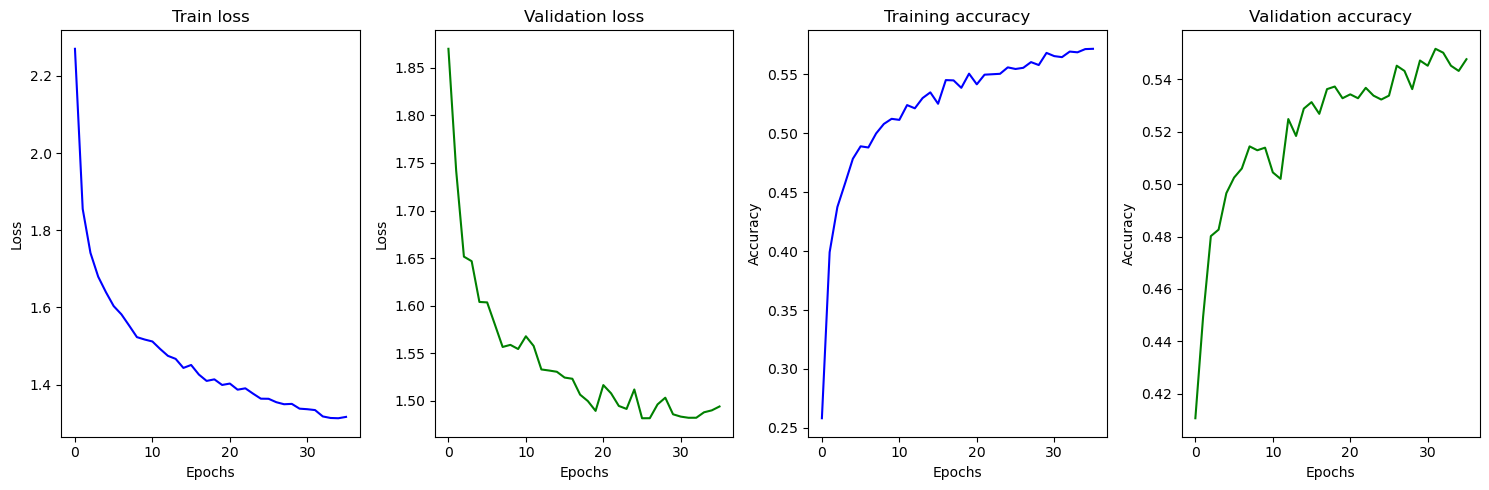

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.5293 - loss: 1.5254

-----------------------------------------------------------------

Starting Fold Number  2



2024-08-23 16:55:50.422196: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fitting the model:

Training time:  22.64  s
Stopped at epoch  55


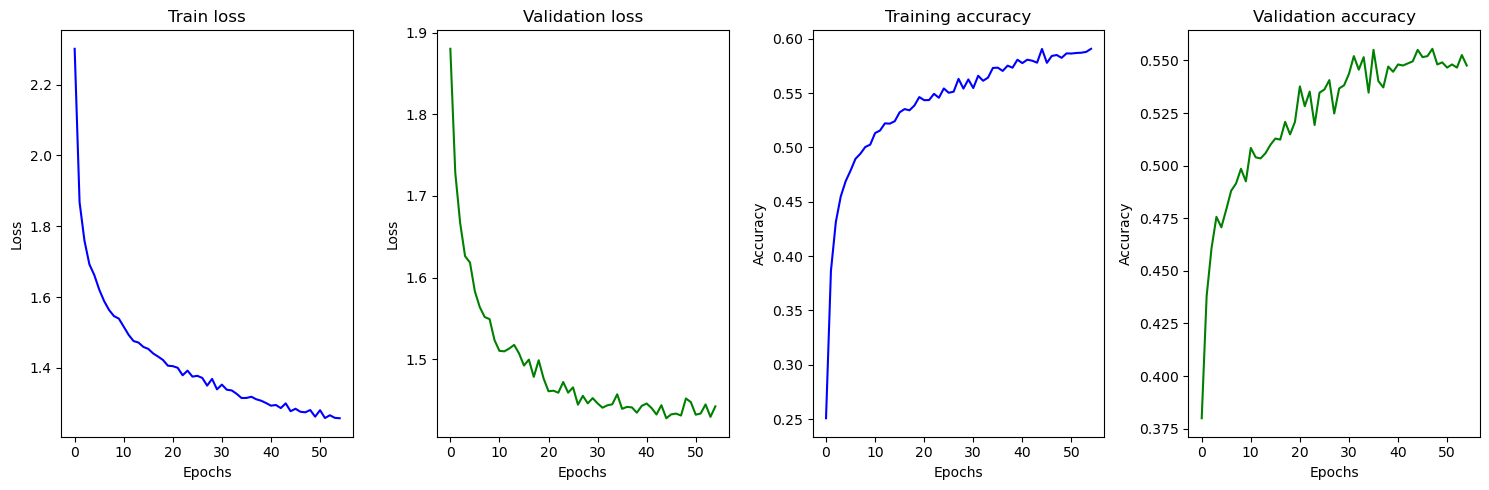

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.5504 - loss: 1.4330

-----------------------------------------------------------------

Starting Fold Number  3



2024-08-23 16:56:13.804807: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fitting the model:

Training time:  19.73  s
Stopped at epoch  46


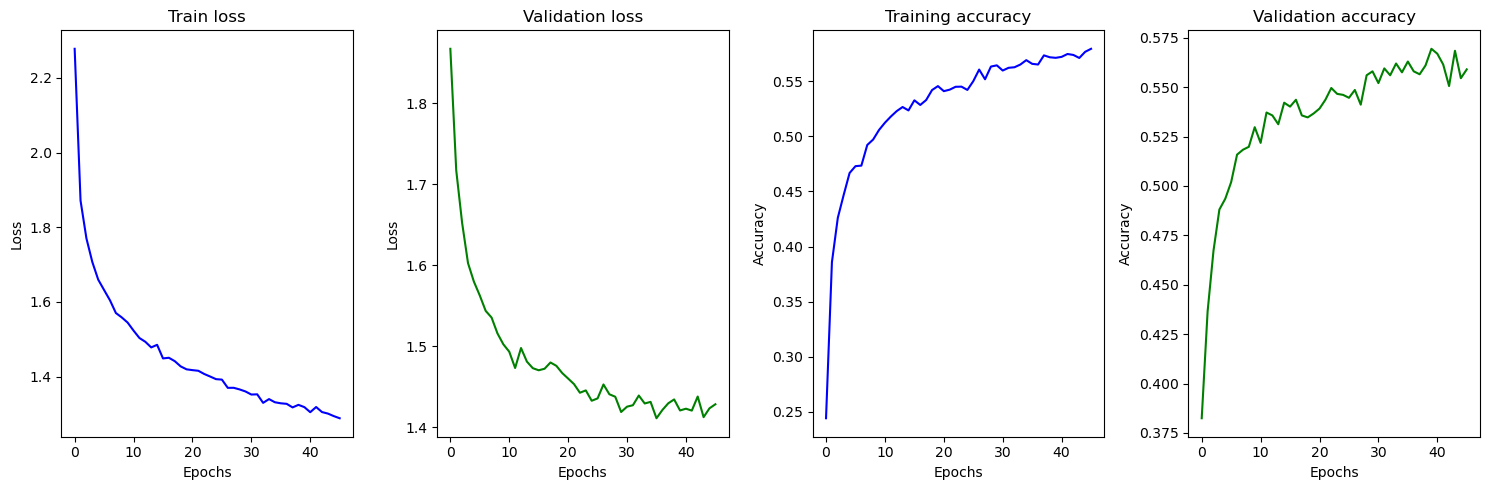

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.5679 - loss: 1.4101

-----------------------------------------------------------------

Starting Fold Number  4

Fitting the model:

Training time:  24.11  s
Stopped at epoch  57


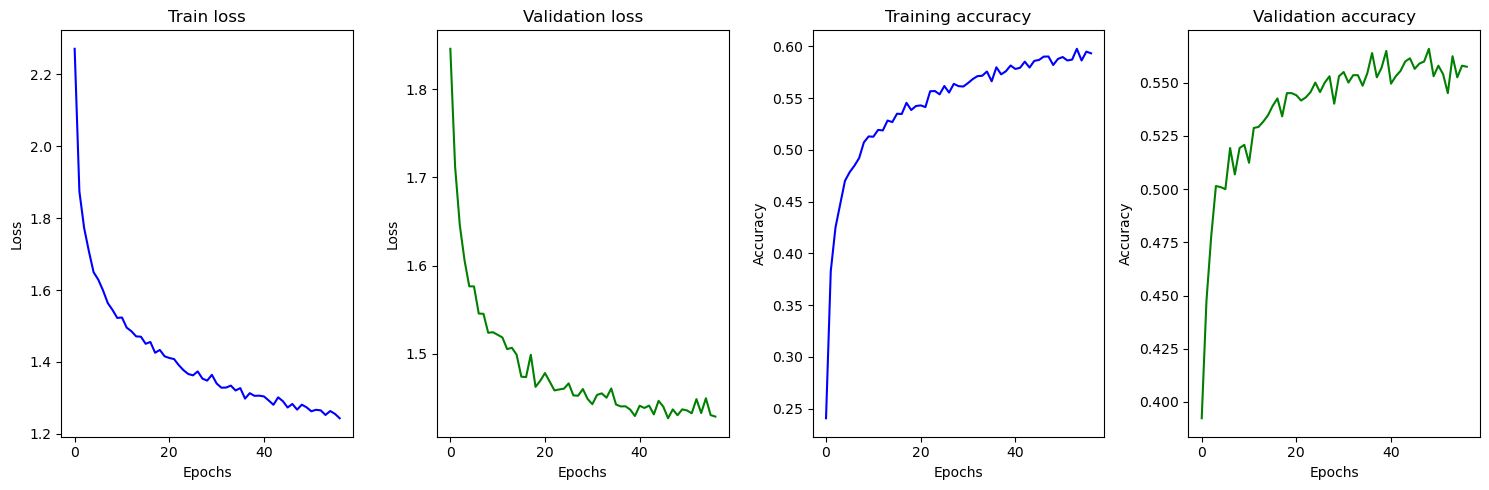

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.5678 - loss: 1.3796

-----------------------------------------------------------------

Starting Fold Number  5



2024-08-23 16:56:59.352817: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fitting the model:

Training time:  21.32  s
Stopped at epoch  50


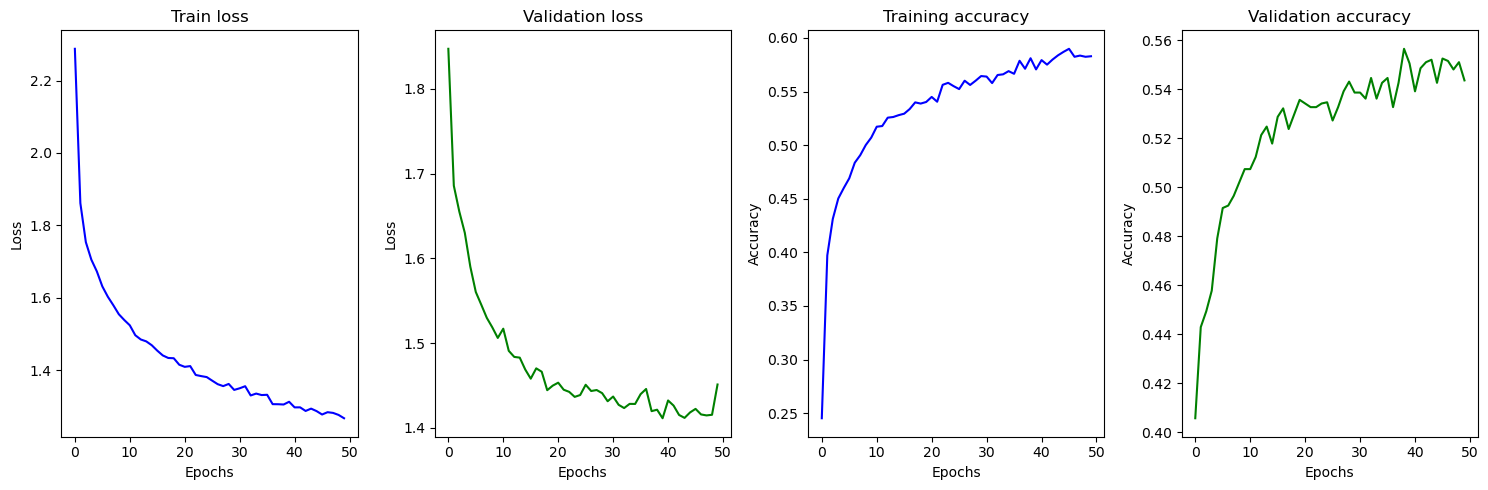

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.5505 - loss: 1.4639

-----------------------------------------------------------------



In [19]:
# Number of folds
model_selection = True
if model_selection:
    n_splits = 5
    batch_s = 32
    index = 1

    # KFold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracy_per_fold = []
    conf_matrix = np.zeros((15,15))

    epochs_per_fold = []

    for train_index, val_index in kf.split(train_df):
        
        print("Starting Fold Number ", index)
        print()
        
        index += 1      
        
        df_train, df_val = train_df.iloc[train_index], train_df.iloc[val_index]
        
        # Convert to TensorFlow datasets
        train_dataset, inp_shape = create_dataset(df_train, batch_s, use_kpoints=use_kpoints, use_object=use_object)
        val_dataset, _ = create_dataset(df_val, batch_s, use_kpoints=use_kpoints, use_object=use_object)
        
        print("Fitting the model:")
        print()
        
        start = time.time()
        
        # Create a new instance of the model
        model = create_model(input_shape=inp_shape)
        
        early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

        results = model.fit(train_dataset,
                            epochs=1000,
                            validation_data=val_dataset, 
                            callbacks=[early_stop_callback], verbose = 0)
        
        epochs = len(results.history['loss'])
        epochs_per_fold.append(epochs)

        end = time.time()
        print('Training time: ', round(end-start,2), " s")
        
        plot_train(results)
        
        # compute predicted labels
        output_vector = model.predict(val_dataset)
        predicted_labels = np.argmax(output_vector[:,:], axis=1)

        extracted_labels = []
        for _, label in val_dataset:
            extracted_labels.extend(label.numpy().tolist())

        true_labels = np.array(extracted_labels)
        
        # compute the confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels)
        #print(cm)
        conf_matrix = conf_matrix + cm
        
        # Evaluate the model
        val_loss, val_accuracy = model.evaluate(val_dataset)
        accuracy_per_fold.append(val_accuracy)
        
        print()
        print('-----------------------------------------------------------------')
        print()

    avg_epochs = np.mean(epochs_per_fold)
else:
    avg_epochs = 60

### Analyze the results

In [20]:
# get the label from the category
labels = df.groupby('category').first()['label']
labels = np.array(labels).tolist()
labels[9] = 'music'

In [21]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, threshold=0.1):
    #normalize cm
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(11, 6))
    ax = sns.heatmap(cm_normalized, annot=False, cmap='Greens', vmin=0, vmax=1, cbar=True, xticklabels=labels, yticklabels=labels)
    
    # Annotate only the main diagonal with rounded values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j or cm_normalized[i, j] > threshold:
                if cm_normalized[i, j] < 0.7:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='black', fontsize=14)
                else:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='white', fontsize=14)    
                
    # Labels, title and axes
    ax.set_title("Neural Network")
    ax.set_xlabel('Predicted labels', fontsize = 14)
    ax.set_ylabel('True labels', fontsize = 14)
    plt.xticks(rotation=60)
    
    plt.show()

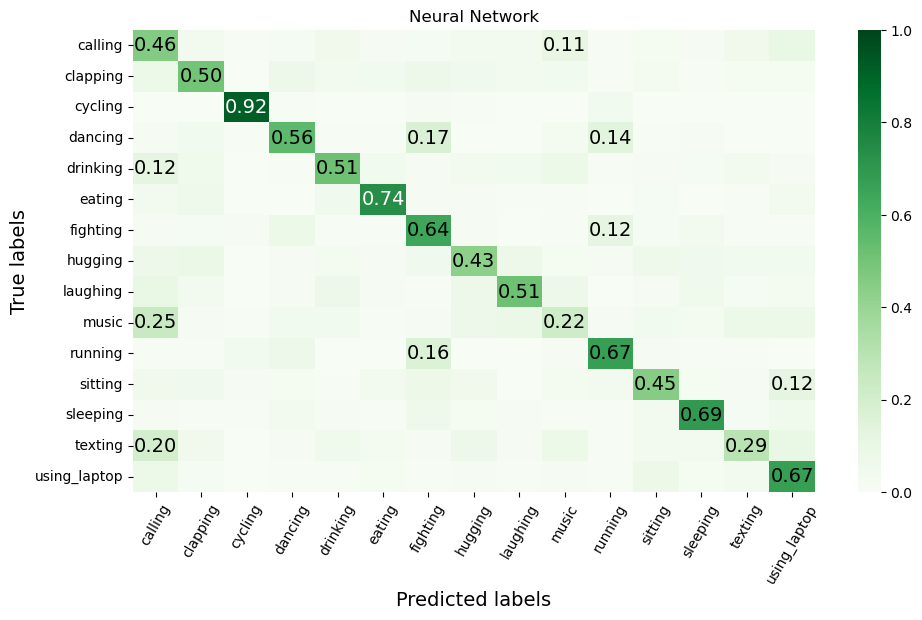

In [22]:
if model_selection:
    plot_confusion_matrix(conf_matrix)

In [23]:
def class_specific_metrics(cm, class_labels = labels):
    # Compute the confusion matrix

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

In [24]:
if model_selection:
    val_metrics = class_specific_metrics(conf_matrix)
    val_metrics

### Fit of the selected model on the training set

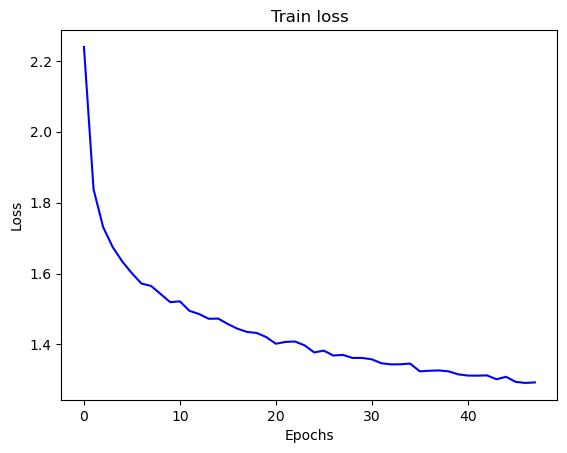

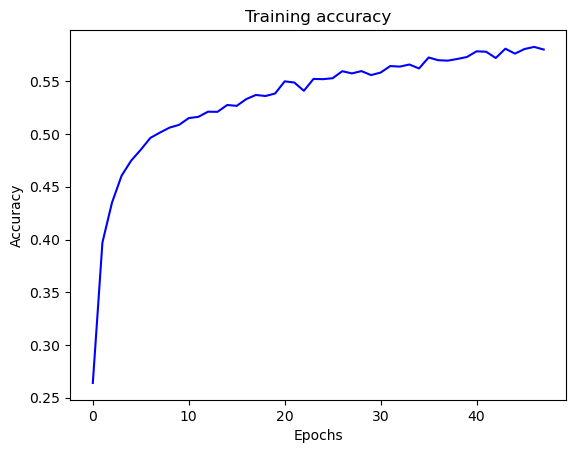

In [25]:
# fit the model on the whole training set
batch_s = 32
train_dataset, inp_shape = create_dataset(train_df, batch_s, use_kpoints=use_kpoints, use_object=use_object)

model = create_model(input_shape=inp_shape)

results = model.fit(train_dataset,
                    epochs=int(avg_epochs), verbose=0)

train_loss = results.history['loss']
train_accuracy = results.history['accuracy']

plt.plot(train_loss, 'b')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(train_accuracy, 'b')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Test 

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.5653 - loss: 1.3352
Test accuracy: 0.5516
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


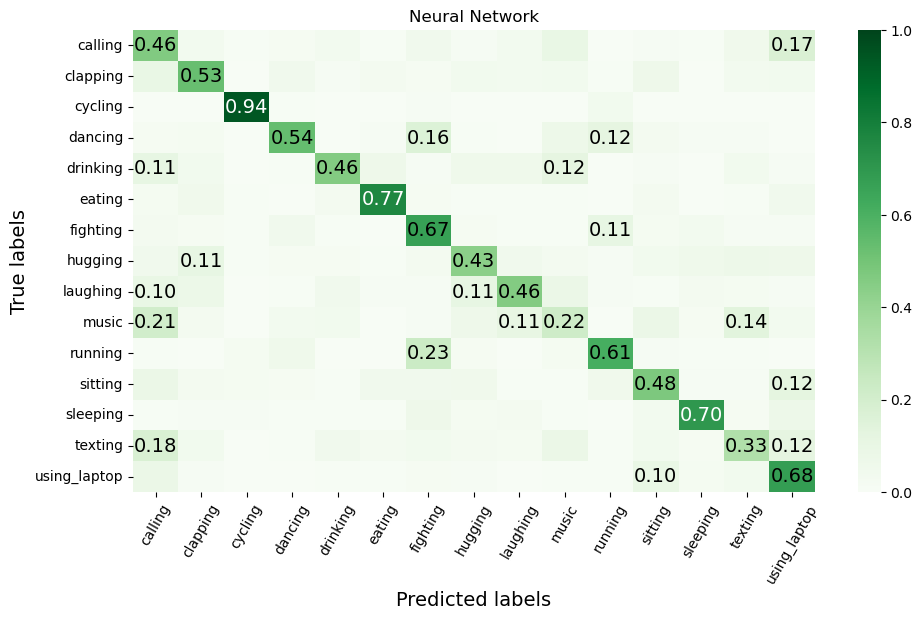

,Accuracy,Sensitivity,Specificity,Precision
calling,0.897619,0.464286,0.928571,0.317073
clapping,0.936111,0.529762,0.965136,0.520468
cycling,0.990476,0.940476,0.994048,0.918605
dancing,0.950794,0.535714,0.980442,0.661765
drinking,0.946825,0.458333,0.981718,0.641667
eating,0.969841,0.767857,0.984269,0.777108
fighting,0.929365,0.666667,0.948129,0.478632
hugging,0.931746,0.434524,0.967262,0.486667
laughing,0.940079,0.458333,0.974490,0.562044
music,0.908730,0.220238,0.957908,0.272059


In [26]:
# Evaluate the model on the test set

test_dataset, _ = create_dataset(test_df, batch_s, use_kpoints=use_kpoints, use_object=use_object)

test_loss, test_accuracy = model.evaluate(test_dataset)

print(f'Test accuracy: {test_accuracy:.4f}')

# compute predicted labels
output_vector = model.predict(test_dataset)
predicted_labels = np.argmax(output_vector[:,:], axis=1)

extracted_labels = []
for _, label in test_dataset:
    extracted_labels.extend(label.numpy().tolist())

true_labels = np.array(extracted_labels)

# compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

plot_confusion_matrix(cm)

test_metrics = class_specific_metrics(cm)
test_metrics

Accuracy = (true positive + true negative) / total

Sensitivity = true positive / (true positive + false negative)

Specificity = true negative / (true negative + false positive)

Precision = true positive / (true positive + false positive)

In [29]:
# helper function
def fitFFNN(file_name, use_kpoints=True, use_object=True):
    
    df = pd.read_pickle(data_directory + '/' + file_name + '.pkl')

    # apply the function to the dataframe
    df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
    df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
    df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
    df['category'] = df['category'].apply(lambda x: np.array(x))
    df['obj_input'] = df.apply(lambda x: np.sum(x['object']*x['obj_vector'], axis=0), axis=1)
    df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())
    
    print('Loaded dataset ', file_name)
    
    train_df, test_df = train_test_split_df(df, 0.2)

    train_dataset, train_shape = create_dataset(train_df, use_kpoints=use_kpoints, use_object=use_object, batch_size=32)
    test_dataset, test_shape = create_dataset(test_df, use_kpoints=use_kpoints, use_object=use_object, batch_size=32)

    # Create a new instance of the model
    model = create_model(input_shape=train_shape)

    # Train the model
    results = model.fit(train_dataset, epochs=int(avg_epochs), verbose=0)
    
    # compute predicted labels
    output_vector = model.predict(test_dataset)
    predicted_labels = np.argmax(output_vector[:,:], axis=1)

    extracted_labels = []
    for _, label in test_dataset:
        extracted_labels.extend(label.numpy().tolist())

    true_labels = np.array(extracted_labels)
    
    # compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Evaluate the model
    val_accuracy = accuracy_score(true_labels, predicted_labels)
    print("Accuracy:", round(val_accuracy,3))
    
    plot_confusion_matrix(cm)
    
    test_metrics = class_specific_metrics(cm)
    print(test_metrics)

    return cm

Loaded dataset  movenet_thunder_mobilenet_large
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.552


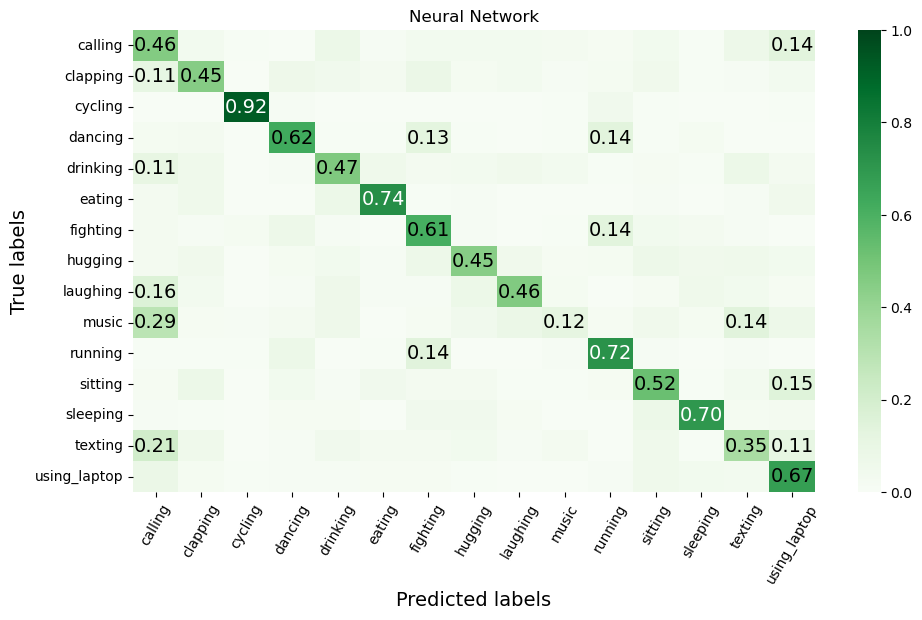

              Accuracy  Sensitivity  Specificity  Precision
calling       0.889683     0.458333     0.920493   0.291667
clapping      0.931746     0.452381     0.965986   0.487179
cycling       0.991270     0.922619     0.996173   0.945122
dancing       0.949206     0.625000     0.972364   0.617647
drinking      0.932540     0.470238     0.965561   0.493750
eating        0.967063     0.738095     0.983418   0.760736
fighting      0.930159     0.613095     0.952806   0.481308
hugging       0.938095     0.446429     0.973214   0.543478
laughing      0.944048     0.464286     0.978316   0.604651
music         0.928968     0.119048     0.986820   0.392157
running       0.951984     0.720238     0.968537   0.620513
sitting       0.932937     0.523810     0.962160   0.497175
sleeping      0.962698     0.702381     0.981293   0.728395
texting       0.921032     0.351190     0.961735   0.395973
using_laptop  0.932540     0.672619     0.951105   0.495614


In [30]:
cm_th_lg = fitFFNN('movenet_thunder_mobilenet_large')

Loaded dataset  movenet_lightning_mobilenet_large
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.571


2024-08-23 16:59:26.151879: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


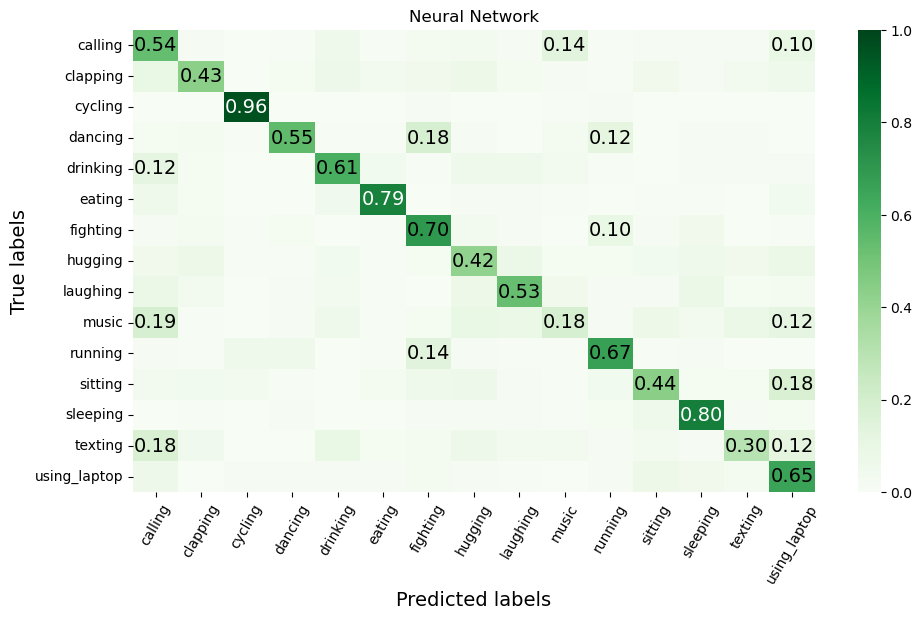

              Accuracy  Sensitivity  Specificity  Precision
calling       0.907143     0.535714     0.933673   0.365854
clapping      0.939683     0.434524     0.975765   0.561538
cycling       0.988492     0.958333     0.990646   0.879781
dancing       0.957937     0.547619     0.987245   0.754098
drinking      0.945238     0.607143     0.969388   0.586207
eating        0.973413     0.785714     0.986820   0.809816
fighting      0.938492     0.696429     0.955782   0.529412
hugging       0.923016     0.416667     0.959184   0.421687
laughing      0.943254     0.529762     0.972789   0.581699
music         0.921429     0.184524     0.974065   0.336957
running       0.951190     0.666667     0.971514   0.625698
sitting       0.936111     0.440476     0.971514   0.524823
sleeping      0.959127     0.803571     0.970238   0.658537
texting       0.932540     0.303571     0.977466   0.490385
using_laptop  0.925000     0.654762     0.944303   0.456432


In [31]:
cm_lh_lg = fitFFNN('movenet_lightning_mobilenet_large')

Loaded dataset  movenet_thunder_mobilenet_small
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.539


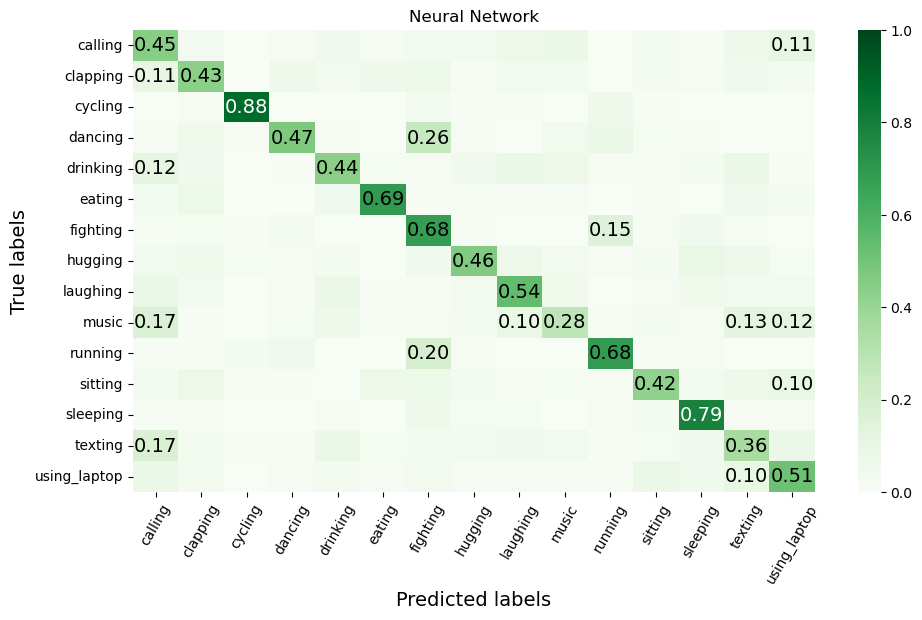

              Accuracy  Sensitivity  Specificity  Precision
calling       0.903968     0.446429     0.936650   0.334821
clapping      0.929365     0.434524     0.964711   0.467949
cycling       0.984921     0.875000     0.992772   0.896341
dancing       0.948413     0.470238     0.982568   0.658333
drinking      0.932937     0.440476     0.968112   0.496644
eating        0.963889     0.690476     0.983418   0.748387
fighting      0.918651     0.678571     0.935799   0.430189
hugging       0.941667     0.464286     0.975765   0.577778
laughing      0.936905     0.541667     0.965136   0.526012
music         0.924603     0.279762     0.970663   0.405172
running       0.953968     0.684524     0.973214   0.646067
sitting       0.937698     0.422619     0.974490   0.541985
sleeping      0.958333     0.785714     0.970663   0.656716
texting       0.912698     0.357143     0.952381   0.348837
using_laptop  0.929762     0.511905     0.959609   0.475138


In [32]:
cm_th_sm = fitFFNN('movenet_thunder_mobilenet_small')

Loaded dataset  movenet_lightning_mobilenet_small
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.544


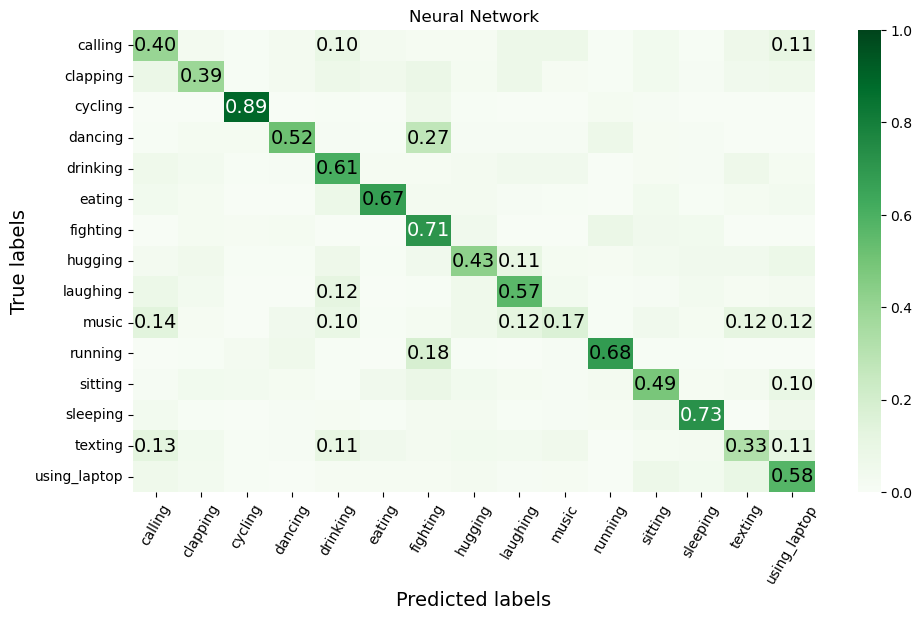

              Accuracy  Sensitivity  Specificity  Precision
calling       0.914683     0.398810     0.951531   0.370166
clapping      0.934127     0.386905     0.973214   0.507812
cycling       0.983333     0.892857     0.989796   0.862069
dancing       0.950794     0.517857     0.981718   0.669231
drinking      0.926587     0.607143     0.949405   0.461538
eating        0.962302     0.672619     0.982993   0.738562
fighting      0.920238     0.714286     0.934949   0.439560
hugging       0.932937     0.428571     0.968963   0.496552
laughing      0.936111     0.565476     0.962585   0.519126
music         0.923016     0.166667     0.977041   0.341463
running       0.961111     0.684524     0.980867   0.718750
sitting       0.934921     0.488095     0.966837   0.512500
sleeping      0.962302     0.726190     0.979167   0.713450
texting       0.921032     0.327381     0.963435   0.390071
using_laptop  0.923810     0.577381     0.948554   0.444954


In [33]:
cm_lh_sm = fitFFNN('movenet_lightning_mobilenet_small')